In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange

from utils import load_mnist, minibatches
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()

In [3]:
import torch
from torch import nn
from torch.autograd import Variable

class View(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(*self.shape)
    
class Normal(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.mu = torch.nn.Sequential(
            nn.Linear(input, output),
            nn.ReLU()
        )
        self.log_std = torch.nn.Sequential(
            nn.Linear(input, output),
            nn.ReLU()
        )
        
    def forward(self, x):
        mu, log_std = self.mu(x), self.log_std(x)
        eps = Variable(torch.randn(*mu.size())).cuda()
        return mu + log_std.exp() * eps, mu, log_std
    
    @staticmethod
    def divergence(mu, log_std):
        return (-1 - 2 * log_std + mu ** 2 + torch.exp(2 * log_std)).sum() * 0.5

class VariationalAutoEncoder(nn.Module):
    def __init__(self, dim=40):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            View(-1, 28 ** 2),
            nn.Linear(28 ** 2, 400),
            nn.ReLU(),
        )
        self.normal = Normal(400, dim)
        self.decoder = torch.nn.Sequential(
            nn.Linear(dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 ** 2),
            nn.Sigmoid(),
            View(-1, 1, 28, 28),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x, mu, log_std = self.normal(x)
        return self.decoder(x), mu, log_std
    
    def encode(self, x):
        x = self.normal(self.encoder(x))[0]
        return x

net = VariationalAutoEncoder().cuda()
criterion = torch.nn.BCELoss(size_average=False)
losses = []

In [17]:
# I trained it 30 epochs with lr == 1e-3 and 20 epochs with lt == 1e-8
optimizer = torch.optim.Adam(net.parameters(), lr=1e-8)

In [25]:
epochs = 10
batch_size = 1000
freq = 2000 / batch_size

In [26]:
for epoch in range(epochs):
    ep = 'Epoch %d: ' % epoch
    mean_loss = 0
    step = 0
    bar = tqdm(minibatches(X_train, y_train, batch_size=batch_size), leave=False, 
               total=(epochs-epoch) * len(X_train) // batch_size)
    for x, _ in bar:
        x = Variable(torch.from_numpy(x)).cuda()
        
        y_pred, mu, log_std = net(x)
        loss = criterion(y_pred, x) + Normal.divergence(mu, log_std)
        mean_loss += loss.cpu().data[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step += 1
        if step >= freq:
            losses.append(mean_loss / step)
            bar.set_description(ep + str(losses[-1]))
            mean_loss = step = 0
    if step:
        losses.append(mean_loss / step)
        bar.set_description(ep + str(losses[-1]))

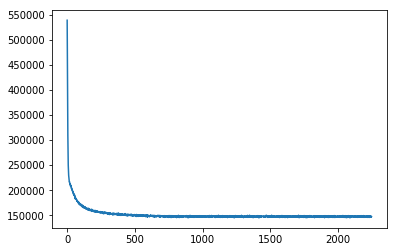

In [27]:
plt.plot(losses)

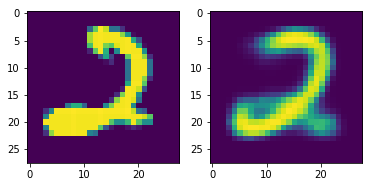

In [28]:
x = X_train[[1010]]
y = net(Variable(torch.from_numpy(x)).cuda())[0].cpu().data.numpy()
ax = plt.subplots(1, 2)[1]
ax[0].imshow(x[0][0], interpolation='none')
ax[1].imshow(y[0][0], interpolation='none')

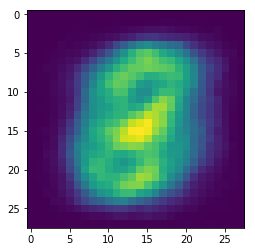

In [35]:
plt.imshow(net.decoder(Variable(torch.ones(1, 40) - ).cuda())[0,0].cpu().data.numpy())